# Making Sentinel 3 FRP data great again

Sentinel 3 data is stored in an annoying format. The data is pretty much a CSV file, but you get it inside a netcdf. This is annoying.

Let's see how this works with the big Portuguese fires from 2024. Here's the [Wikipedia entry](https://en.wikipedia.org/wiki/2024_Portugal_wildfires)

This query uses the S3 Level 2 NTC (non time critical) FRP product. The end product is a pandas dataframe with the FRP values and lat/long/time, etc.

The library works by searching (it's a wrapper on STAC), and then passing the items to the Sentinel3FRPLoader class, which handles the downloading and unpacking of the data. The processing is multithreaded, but it still takes forever. I'm not even sure how the `max_items` option works here.... I set to 100 because.... well, I don't know. 

In [1]:
import cdse_grab

geom = {
    "type": "Polygon",
    "coordinates": [
        [
            [-9.56, 36.96],
            [-9.56, 42.18],
            [-6.19, 42.18],
            [-6.19, 36.96],
            [-9.56, 36.96],
        ]
    ],
}

items = cdse_grab.StacSearcher().search(
    datetime_range="2024-09-10/2024-09-30", geom=geom, max_items=100
)

# Check the number of items found
print(f"Found {len(items)} items.")

# Now read the items into a  Sentinel3 object
s3 = cdse_grab.Sentinel3FRPLoader(items)
# Convert to a dataframe:
df = s3.load_asset("FRP_in")

Found 100 items.


Loading FRP_in:   0%|          | 0/100 [00:00<?, ?it/s]

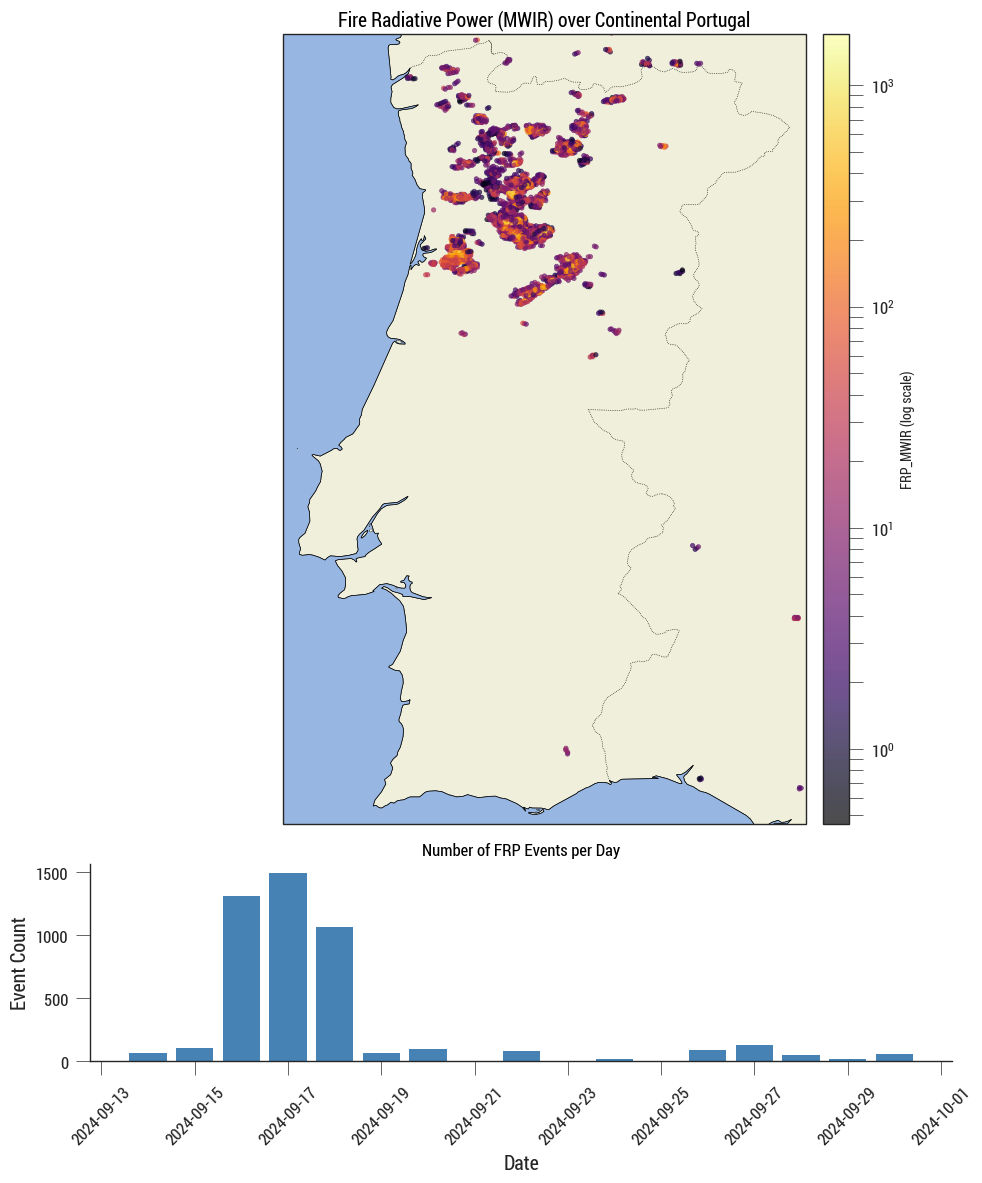

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm

# Assume df has columns: latitude, longitude, acquisition_time, FRP_MWIR

# Convert acquisition_time to datetime if not already
df["acquisition_time"] = pd.to_datetime(df["acquisition_time"])

# --- Prepare the two subplots: one tall map, one short bar plot ---
fig = plt.figure(figsize=(10, 12))

# Define grid layout with constrained height ratios
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[4, 1])  # 80% / 20%

# --- Top subplot: Map with scatter points ---
ax_map = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax_map.set_title(
    "Fire Radiative Power (MWIR) over Continental Portugal", fontsize=14
)

# Set the extent for continental Portugal
ax_map.set_extent([-9.6, -6.1, 36.9, 42.2], crs=ccrs.PlateCarree())

# Add geographic context
ax_map.add_feature(cfeature.COASTLINE)
ax_map.add_feature(cfeature.BORDERS, linestyle=":")
ax_map.add_feature(cfeature.LAND, edgecolor="black")
ax_map.add_feature(cfeature.OCEAN)

# Plot scatter points
sc = ax_map.scatter(
    df["longitude"],
    df["latitude"],
    c=df["FRP_MWIR"],
    cmap="inferno",
    norm=LogNorm(),
    s=10,
    alpha=0.7,
    transform=ccrs.PlateCarree(),
)

# Add colorbar
cbar = plt.colorbar(
    sc, ax=ax_map, orientation="vertical", pad=0.02, aspect=30
)
cbar.set_label("FRP_MWIR (log scale)", fontsize=10)

# --- Bottom subplot: Daily event count ---
ax_hist = fig.add_subplot(gs[1])
ax_hist.set_title("Number of FRP Events per Day", fontsize=12)

# Count events per day
df_daily = df.groupby(df["acquisition_time"].dt.date).size()

# Plot bar chart
ax_hist.bar(df_daily.index, df_daily.values, color="steelblue")
ax_hist.set_ylabel("Event Count")
ax_hist.set_xlabel("Date")
ax_hist.tick_params(axis="x", rotation=45)

# Layout
plt.tight_layout()
plt.show()